## Trabalho Computacional I
___
### Projeto 2: Butterworth por Transformação Bilinear
ENGC63 - 2023.1

**Discentes:** Gabriel S. de Andrade e Fábio B. Braga Santana

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import read
from IPython.display import Audio
from scipy.fft import fft, fftfreq

### 1. Sinal de Entrada

É interessante conhecermos graficamente os aspectos relacionados ao sinal de entrada tais como sua waveform, resposta em frequência e espectograma. 

#### 1.1. Waveform

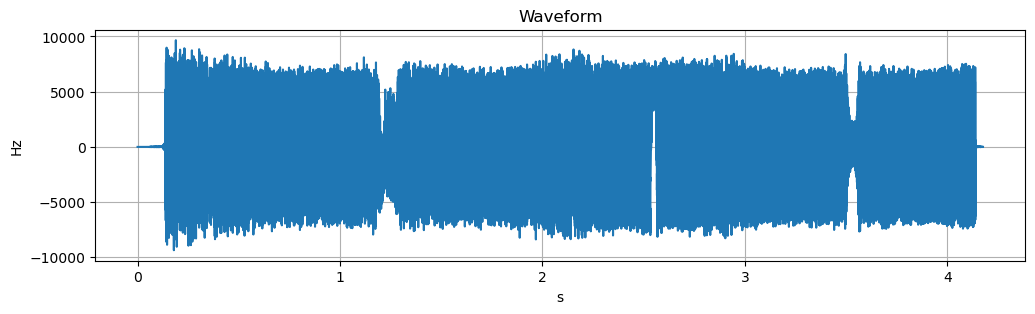

In [2]:
# Define o caminho do arquivo de áudio a ser processado
audio_path = "sample.wav"

# Faz a leitura do arquivo de áudio e coleta a taxa de amostragem e os dados
(sample_rate, samples) = read(audio_path)

# Tamanho do sinal
signal_length = len(samples)

# Período de amostragem do sinal entre 0 e signal_length
period = np.linspace(0, signal_length / sample_rate, signal_length)

# Plota o gráfico do sinal de entrada
plt.figure(figsize=(12, 3))
plt.plot(period, samples)
plt.title("Waveform")
plt.xlabel("s")
plt.ylabel("Hz")
plt.grid(True)
plt.show()

# Exibe o player de audio
Audio(audio_path)

#### 1.2. Resposta em Frequência

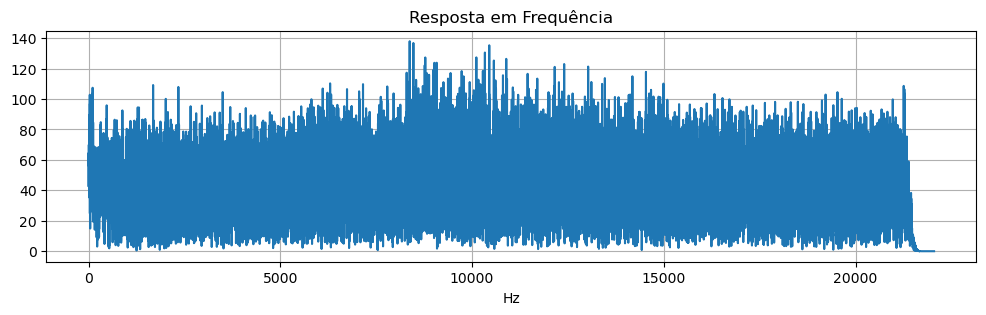

In [3]:
# Vetor contendo os coeficientes da transformada de fourier do sinal
samples_fft = fft(samples)[: signal_length // 2]
magnitude_fft = np.abs(samples_fft)[: signal_length // 2]

Fs = 44100
T = 1.0 / Fs

# frequências positivas correspondentes aos coeficientes da transformada de Fourier do sinal de áudio.
# Essas frequências são calculadas com base no tamanho do sinal e na frequência de amostragem.
frequency_fft = fftfreq(signal_length, T)[: signal_length // 2]

# Plota o gráfico da resposta em frequência do sinal de entrada
plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, (2.0 / signal_length) * magnitude_fft)
plt.title("Resposta em Frequência")
plt.xlabel("Hz")
plt.grid(True)
plt.show()

#### 1.3. Espectograma

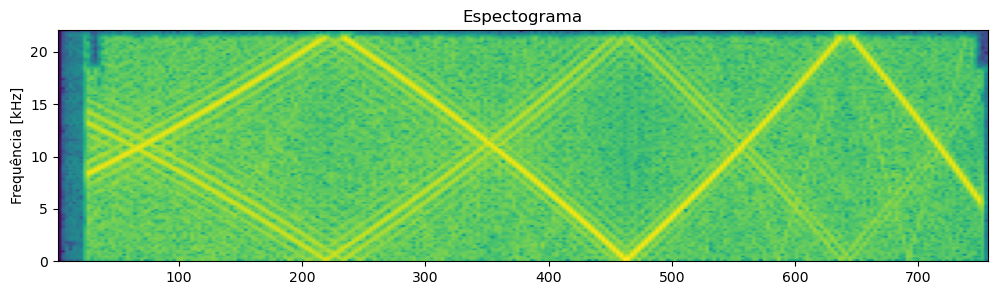

In [4]:
plt.figure(figsize=(12, 3))
plt.specgram(samples, Fs=Fs / 1000, sides="onesided")
plt.title("Espectograma")
plt.ylabel("Frequência [kHz]")
plt.show()

### 2. Butterworth

#### 2.1. Especificações do projeto de filtro

In [5]:
# Frequência de corte [rad/amostra]
wc = 2 * np.pi / 3

# Frequência de amostragem [Hz]
Fs = 44100

# Frequência de corte [Hz]
Fc = round(Fs * wc / (2 * np.pi))

# Ordem do filtro Butterworth
N = 6

# Freq angular de corte [rad/s]
Wc = 2*np.pi*Fc      

#### 2.2. Implementação do filtro

In [6]:
# Gera zpk para uso em cascata
# Zero, polo e ganho
butt_zpk = signal.butter(N, Wc, btype='lowpass', analog=True, output='zpk') 

# Converte zpk para tf (b/a)
butt_tf = signal.zpk2tf(*butt_zpk) 
b, a = butt_tf

butterworth_analog = signal.lti(*butt_tf)      # Filtro analógico
butterworth_analog_zpk = signal.lti(*butt_zpk) # Versão zpk para uso em cascata 

##### 2.3. Transformação Bilinear

In [7]:
# Converte Butterworth para filtro digital por Transformação Linear:
butterworth_discrete = signal.dlti(
    *signal.bilinear(butterworth_analog.num, butterworth_analog.den, fs=Fs)
)

# Versão zpk para uso em cascata
butterworth_discrete_zpk = signal.dlti(
    *signal.bilinear_zpk(
        butterworth_analog_zpk.zeros,
        butterworth_analog_zpk.poles,
        butterworth_analog_zpk.gain,
        fs=Fs,
    )
)  

z = butterworth_discrete_zpk.zeros.copy()
p = butterworth_discrete_zpk.poles.copy()
k = butterworth_discrete_zpk.gain.copy()

sos = signal.zpk2sos(z, p, k)  # Converte zpk para sistemas de segunda ordem (cascata)

# Gera parâmetros para plotagem dos filtros
Wz, Hz = signal.freqz(butterworth_discrete.num, butterworth_discrete.den)  # Digital
Ws, Hs = signal.freqs(
    butterworth_analog.num, butterworth_analog.den, worN=Fs * Wz
)  # Analógico

#### 2.4. Resposta em frequência

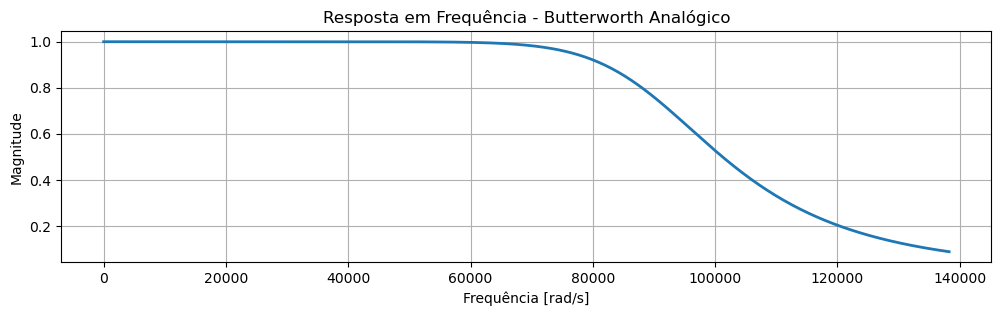

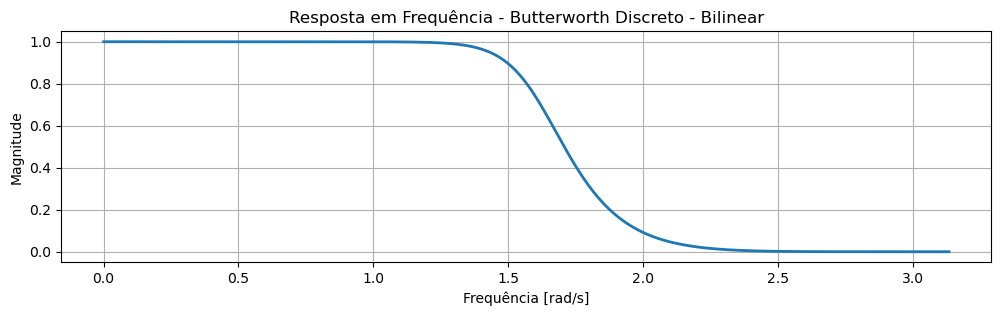

In [8]:
# Plota o gráfico de resposta em frequência do filtro Butterworth analógico
plt.figure(figsize=(12, 3))
plt.plot(Ws, np.abs(Hs), linewidth=2)
plt.title("Resposta em Frequência - Butterworth Analógico")
plt.xlabel("Frequência [rad/s]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

# Plota o gráfico de resposta em frequência do filtro Butterworth discreto
plt.figure(figsize=(12, 3))
plt.plot(Wz, np.abs(Hz), linewidth=2)
plt.title("Resposta em Frequência - Butterworth Discreto - Bilinear")
plt.xlabel("Frequência [rad/s]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

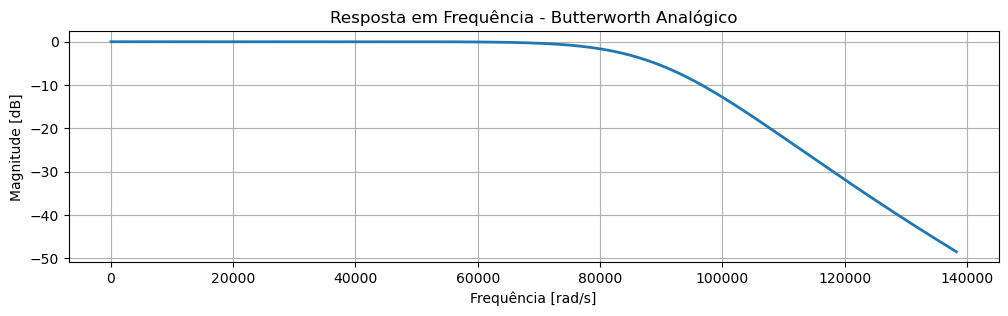

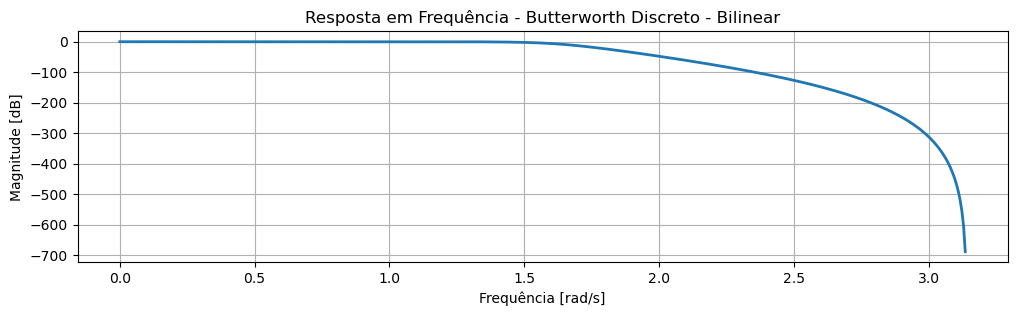

In [9]:
# Plota o gráfico de resposta em frequência do filtro Butterworth analógico
plt.figure(figsize=(12, 3))
plt.plot(Ws, 20 * np.log(np.abs(Hs)), linewidth=2)
plt.title("Resposta em Frequência - Butterworth Analógico")
plt.xlabel("Frequência [rad/s]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.show()

# Plota o gráfico de resposta em frequência do filtro Butterworth discreto
plt.figure(figsize=(12, 3))
plt.plot(Wz, 20 * np.log(np.abs(Hz)), linewidth=2)
plt.title("Resposta em Frequência - Butterworth Discreto - Bilinear")
plt.xlabel("Frequência [rad/s]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.show()

#### 2.5. Diagrama de polos e zeros

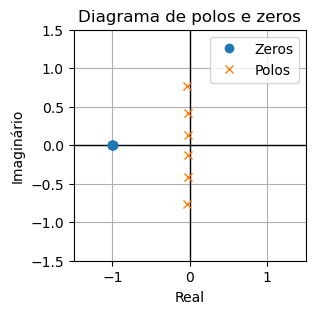

In [10]:
# Plota o diagrama de polos e zeros
plt.figure(figsize=(3, 3))
plt.vlines(0, -1.5, 1.5, color="k", linestyles="-", linewidth=1)
plt.hlines(0, -1.5, 1.5, color="k", linestyles="-", linewidth=1)
plt.plot(
    butterworth_discrete.zeros.real, butterworth_discrete.zeros.imag, "o", label="Zeros"
)
plt.plot(
    butterworth_discrete.poles.real, butterworth_discrete.poles.imag, "x", label="Polos"
)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.legend()
plt.title("Diagrama de polos e zeros")
plt.xlabel("Real")
plt.ylabel("Imaginário")
plt.grid(True)
plt.show()

#### 2.6. Magnitude

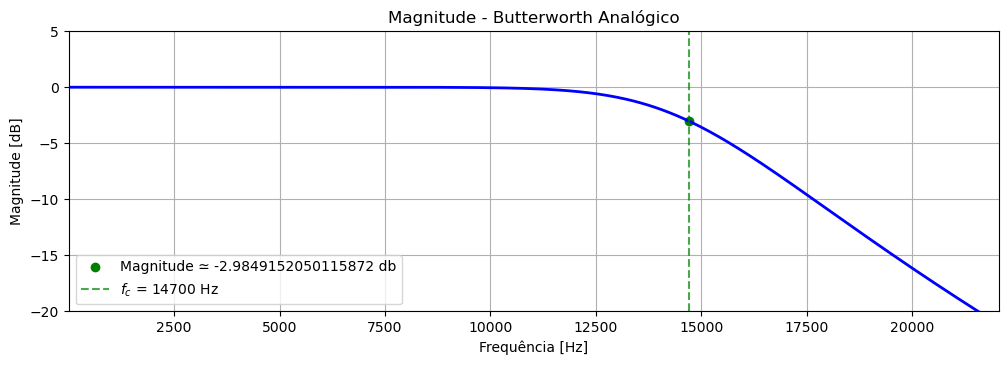

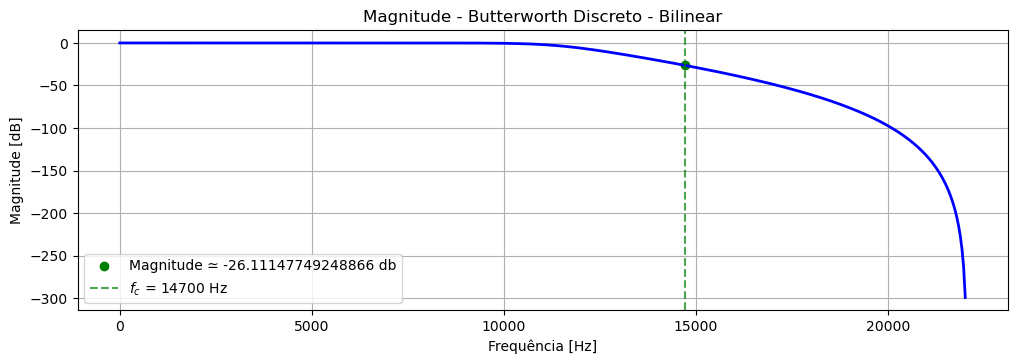

In [11]:
# Calcula a magnitude do filtro analógico e discreto em dB
butterworth_analog_magnitude = 20 * np.log10(abs(Hs))
butterworth_discrete_magnitude = 20 * np.log10(abs(Hz))

# Calcula a frequência do filtro discreto em Hz
Wz_frequency = Wz * Fs / (2 * np.pi)

# Magnitude na frequência de corte
Fc_analog_magnitude = butterworth_analog_magnitude[
    round(Fc / (Wz_frequency[1] - Wz_frequency[0]))
]
Fc_discrete_magnitude = butterworth_discrete_magnitude[
    round(Fc / (Wz_frequency[1] - Wz_frequency[0]))
]

# Plota o gráfico de Magnitude para Butterworth Analógico
plt.figure(figsize=(12, 8))
subplot = plt.subplot(2, 1, 1)
subplot.plot(
    Fc, Fc_analog_magnitude, "go", label=f"Magnitude ≃ {Fc_analog_magnitude} db"
)
subplot.plot(Wz_frequency, butterworth_analog_magnitude, "b", linewidth=2)
subplot.axis([1, Fs / 2, -20, 5])
subplot.set_title("Magnitude - Butterworth Analógico")
subplot.set_xlabel("Frequência [Hz]")
subplot.set_ylabel("Magnitude [dB]")
subplot.grid()
plt.axvline(
    x=Fc, color="green", ls="--", label="$f_c$ = {} Hz".format(round(Fc)), alpha=0.7
)
plt.legend()
plt.show()

# Plota o gráfico de Magnitude para Butterworth Discreto
plt.figure(figsize=(12, 8))
subplot = plt.subplot(2, 1, 1)
subplot.plot(
    Fc, Fc_discrete_magnitude, "go", label=f"Magnitude ≃ {Fc_discrete_magnitude} db"
)
subplot.plot(Wz_frequency, butterworth_discrete_magnitude, "b", linewidth=2)
subplot.set_title("Magnitude - Butterworth Discreto - Bilinear")
subplot.set_xlabel("Frequência [Hz]")
subplot.set_ylabel("Magnitude [dB]")
subplot.grid()
plt.axvline(
    x=Fc, color="green", ls="--", label="$f_c$ = {} Hz".format(round(Fc)), alpha=0.7
)
plt.legend()
plt.show()

### 3. Filtragem

##### [!] Alterando a precisão dos coeficientes

In [12]:
butterworth_discrete_5d = copy.deepcopy(butterworth_discrete)

butterworth_discrete_5d.num = [round(elem, 5) for elem in butterworth_discrete_5d.num]
butterworth_discrete_5d.den = [round(elem, 5) for elem in butterworth_discrete_5d.den]

Wz_5d, Hz_5d = signal.freqz(
    butterworth_discrete_5d.num, butterworth_discrete_5d.den, worN=Fs
)

# Para o método de cascata
z5d, p5d, k5d = signal.tf2zpk(butterworth_discrete_5d.num, butterworth_discrete_5d.den)

In [13]:
butterworth_discrete_4d = copy.deepcopy(butterworth_discrete)

butterworth_discrete_4d.num = [round(elem, 4) for elem in butterworth_discrete_4d.num]
butterworth_discrete_4d.den = [round(elem, 4) for elem in butterworth_discrete_4d.den]

Wz_4d, Hz_4d = signal.freqz(
    butterworth_discrete_4d.num, butterworth_discrete_4d.den, worN=Fs
)

# Para o método de cascata
z4d, p4d, k4d = signal.tf2zpk(butterworth_discrete_4d.num, butterworth_discrete_4d.den)

In [14]:
butterworth_discrete_3d = copy.deepcopy(butterworth_discrete)

butterworth_discrete_3d.num = [round(elem, 3) for elem in butterworth_discrete_3d.num]
butterworth_discrete_3d.den = [round(elem, 3) for elem in butterworth_discrete_3d.den]

Wz_3d, Hz_3d = signal.freqz(
    butterworth_discrete_3d.num, butterworth_discrete_3d.den, worN=Fs
)

# Para o método de cascata
z3d, p3d, k3d = signal.tf2zpk(butterworth_discrete_3d.num, butterworth_discrete_3d.den)

#### 3.1. Cascata

In [15]:
def cascade(samples, z, p, k):
    # Converte TF para SOS (seções de 2a ordem)
    sos = signal.zpk2sos(z, p, k)

    # Filtra entrada pela sequência em cascata das funções
    return signal.sosfilt(sos=sos, x=samples)

##### 3.1.1. Precisão infinita

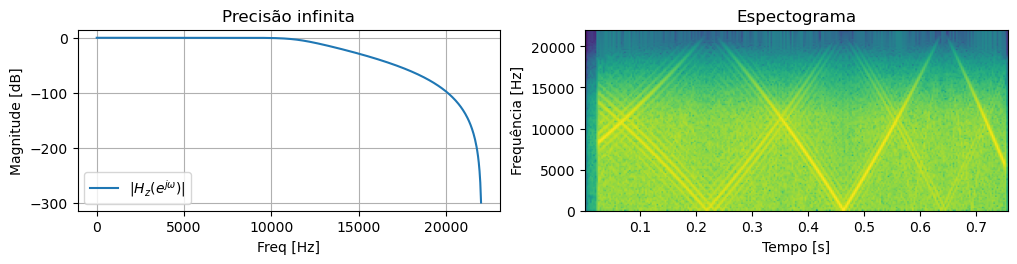

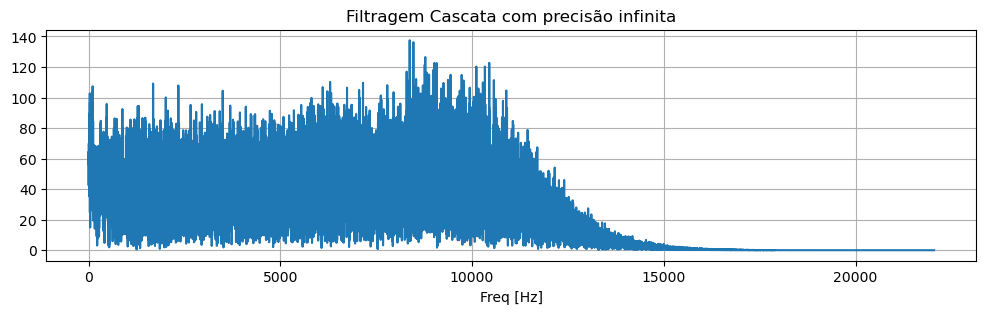

In [16]:
cascade_infi = cascade(
    samples,
    butterworth_discrete_zpk.zeros,
    butterworth_discrete_zpk.poles,
    butterworth_discrete_zpk.gain,
)
N = samples.shape[0]

plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(
    Wz * 1 / (2 * np.pi) * Fs,
    20 * np.log10(np.abs(Hz)),
    label=r"$|H_z(e^{j \omega})|$"
)

plt.title("Precisão infinita")
plt.xlabel("Freq [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.legend()

# Plota espectograma do sinal filtrado
plt.subplot(3, 2, 2)
plt.specgram(cascade_infi, Fs=Fs, sides="onesided")
plt.title("Espectograma")
plt.xlabel("Tempo [s]")
plt.ylabel("Frequência [Hz]")

plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(cascade_infi)[0 : N // 2]))
plt.title("Filtragem Cascata com precisão infinita")
plt.xlabel("Freq [Hz]")
plt.grid(True)
plt.show()

Audio(cascade_infi, rate=sample_rate)

##### 3.1.2. Precisão finita de 5 casas decimais

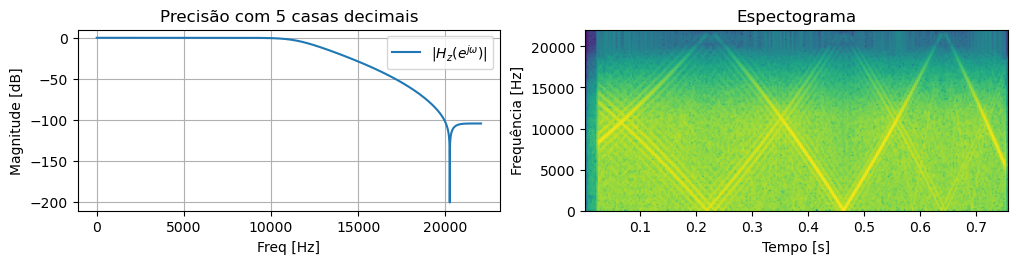

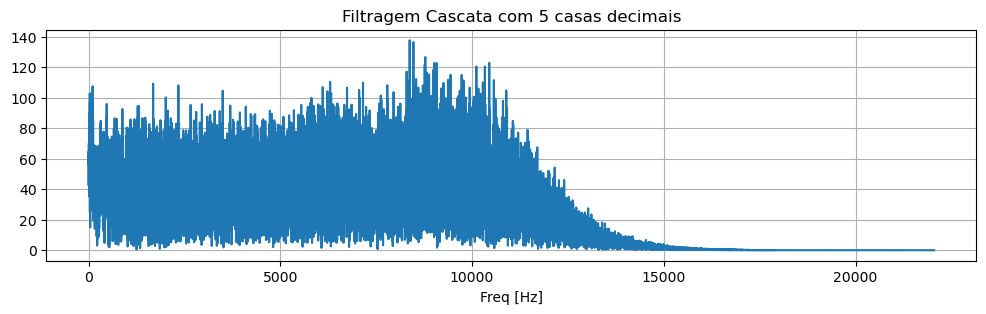

In [17]:
cascade_5d = cascade(
    samples,
    z5d,
    p5d,
    k5d,
)

N = samples.shape[0]

plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(
    Wz_5d * 1 / (2 * np.pi) * Fs,
    20 * np.log10(np.abs(Hz_5d)),
    label=r"$|H_z(e^{j \omega})|$"
)

plt.title("Precisão com 5 casas decimais")
plt.xlabel("Freq [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.legend()

# Plota espectograma do sinal filtrado
plt.subplot(3, 2, 2)
plt.specgram(cascade_5d, Fs=Fs, sides="onesided")
plt.title("Espectograma")
plt.xlabel("Tempo [s]")
plt.ylabel("Frequência [Hz]")

plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(cascade_5d)[0: N // 2]))
plt.title("Filtragem Cascata com 5 casas decimais")
plt.xlabel("Freq [Hz]")
plt.grid(True)
plt.show()

Audio(cascade_5d, rate=sample_rate)


##### 3.1.3. Precisão finita de 4 casas decimais

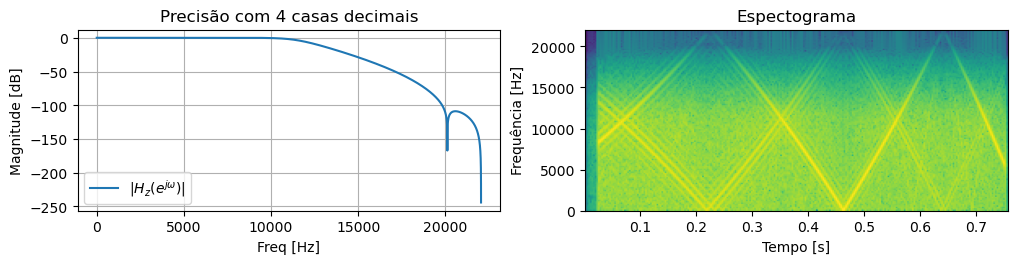

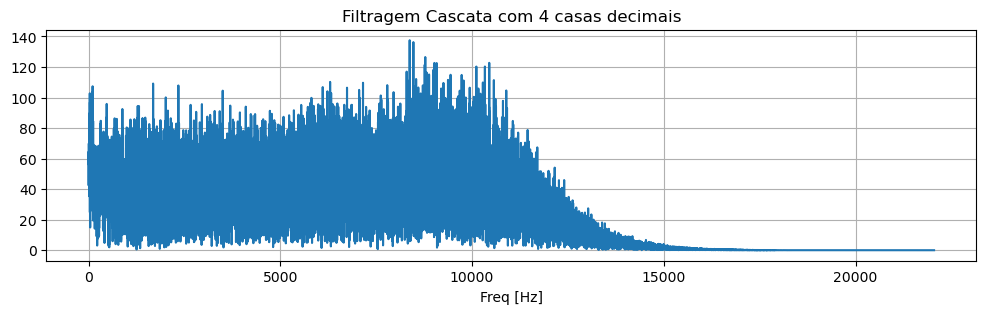

In [18]:
cascade_4d = cascade(
    samples,
    z4d,
    p4d,
    k4d,
)

N = samples.shape[0]

plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(
    Wz_4d * 1 / (2 * np.pi) * Fs,
    20 * np.log10(np.abs(Hz_4d)),
    label=r"$|H_z(e^{j \omega})|$"
)

plt.title("Precisão com 4 casas decimais")
plt.xlabel("Freq [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.legend()

# Plota espectograma do sinal filtrado
plt.subplot(3, 2, 2)
plt.specgram(cascade_4d, Fs=Fs, sides="onesided")
plt.title("Espectograma")
plt.xlabel("Tempo [s]")
plt.ylabel("Frequência [Hz]")

plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(cascade_4d)[0: N // 2]))
plt.title("Filtragem Cascata com 4 casas decimais")
plt.xlabel("Freq [Hz]")
plt.grid(True)
plt.show()

Audio(cascade_4d, rate=sample_rate)


##### 3.1.4. Precisão finita de 3 casas decimais

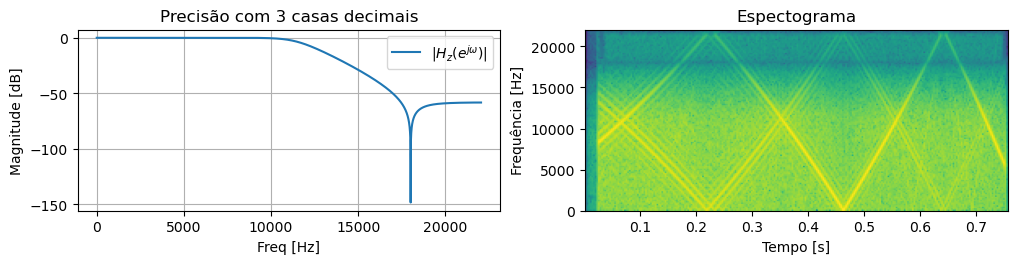

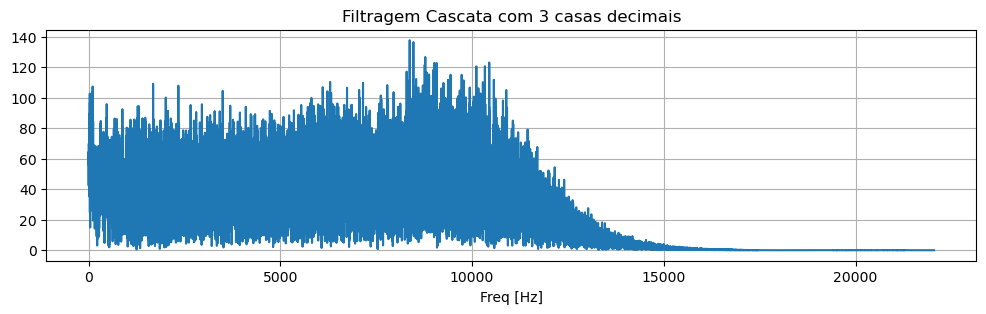

In [19]:
cascade_3d = cascade(
    samples,
    z3d,
    p3d,
    k3d,
)

N = samples.shape[0]

plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(
    Wz_3d * 1 / (2 * np.pi) * Fs,
    20 * np.log10(np.abs(Hz_3d)),
    label=r"$|H_z(e^{j \omega})|$"
)

plt.title("Precisão com 3 casas decimais")
plt.xlabel("Freq [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.legend()

# Plota espectograma do sinal filtrado
plt.subplot(3, 2, 2)
plt.specgram(cascade_3d, Fs=Fs, sides="onesided")
plt.title("Espectograma")
plt.xlabel("Tempo [s]")
plt.ylabel("Frequência [Hz]")

plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(cascade_3d)[0: N // 2]))
plt.title("Filtragem Cascata com 3 casas decimais")
plt.xlabel("Freq [Hz]")
plt.grid(True)
plt.show()

Audio(cascade_3d, rate=sample_rate)


#### 3.2. Direta

In [20]:
def direct_form(signal, b, a):
    # Ordem dos coeficientes do filtro
    M = len(b)
    N = len(a)

    # Construindo o sinal de saída
    y = np.zeros(len(signal))

    for n in range(len(signal)):
        # Somatório dos produtos dos coeficientes b e da entrada
        for i in range(M):
            if n - i >= 0:
                y[n] += b[i] * signal[n - 1]

        # Somatório dos produtos dos coeficientes a e da saída
        for j in range(N):
            if n - j >= 0:
                y[n] -= a[j] * signal[n - j]

    return y

##### 3.2.1. Precisão infinita na forma direta

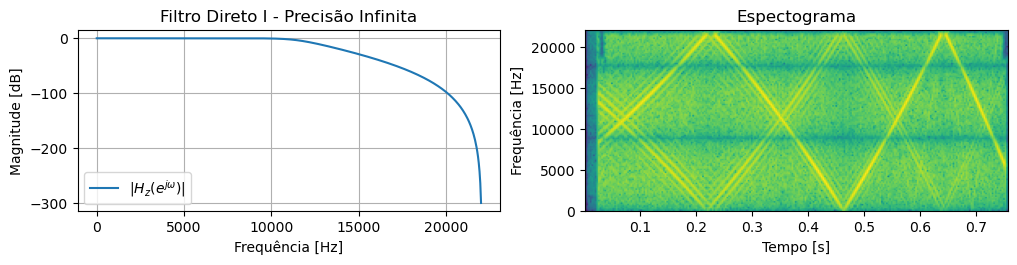

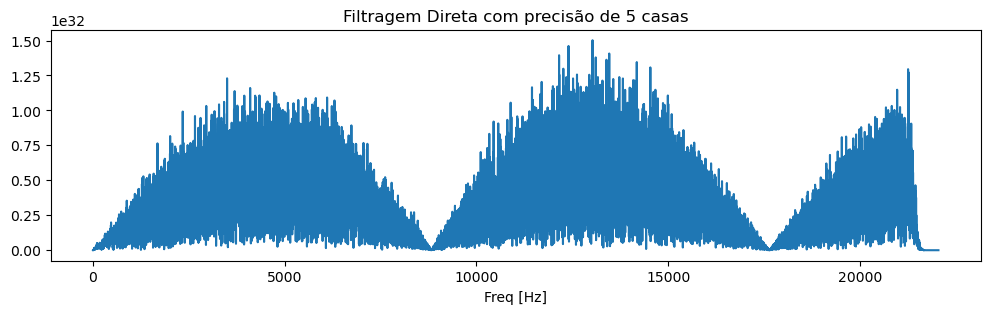

In [21]:
filtered_direct_form_infinity = direct_form(samples, b, a)

plt.figure(figsize=(12, 8))

# Plota gráfico de magnitude do sinal filtrado
plt.subplot(3, 2, 1)
plt.plot(
    Wz * Fs / (2 * np.pi),
    butterworth_discrete_magnitude,
    label=r"$|H_z(e^{j \omega})|$",
)
plt.title("Filtro Direto I - Precisão Infinita")
plt.xlabel("Frequência [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.legend()

# Plota espectograma do sinal filtrado
plt.subplot(3, 2, 2)
plt.specgram(filtered_direct_form_infinity, Fs=Fs, sides="onesided")
plt.title("Espectograma")
plt.xlabel("Tempo [s]")
plt.ylabel("Frequência [Hz]")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(filtered_direct_form_infinity)[0: N // 2]))
plt.title("Filtragem Direta com precisão de 5 casas")
plt.xlabel("Freq [Hz]")
plt.show()

Audio(filtered_direct_form_infinity, rate=sample_rate)


##### 3.2.2. Precisão finita de 5 casas decimais

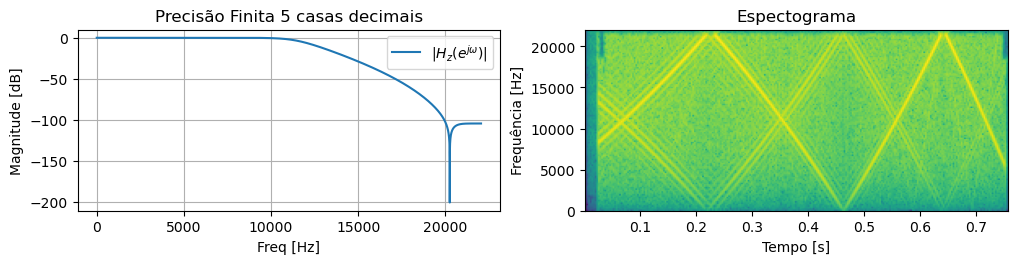

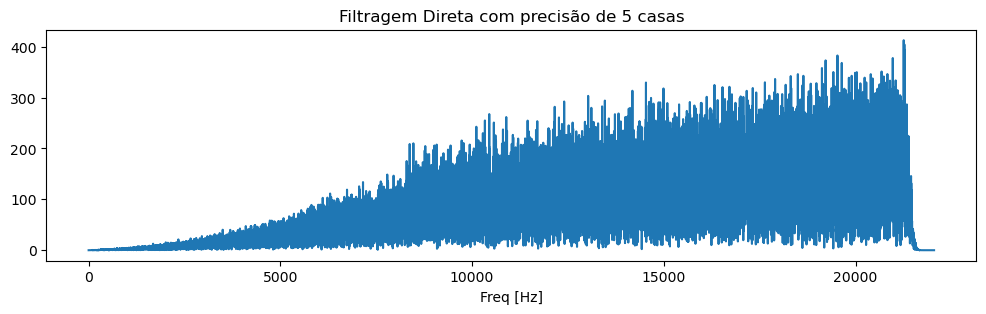

In [22]:
direct_5 = direct_form(
    samples, butterworth_discrete_5d.num, butterworth_discrete_5d.den
)
N = samples.shape[0]

plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(
    Wz_5d * 1 / (2 * np.pi) * Fs,
    20 * np.log10(np.abs(Hz_5d)),
    label=r"$|H_z(e^{j \omega})|$",
)
# plt.axis((ax))
plt.legend()
plt.title("Precisão Finita 5 casas decimais")
plt.xlabel("Freq [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)

# Plota espectograma do sinal filtrado
plt.subplot(3, 2, 2)
plt.specgram(direct_5, Fs=Fs, sides="onesided")
plt.title("Espectograma")
plt.xlabel("Tempo [s]")
plt.ylabel("Frequência [Hz]")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(direct_5)[0 : N // 2]))
plt.title("Filtragem Direta com precisão de 5 casas")
plt.xlabel("Freq [Hz]")
plt.show()

Audio(direct_5, rate=sample_rate)

##### 3.2.3. Preciasão finita de 4 casas decimais

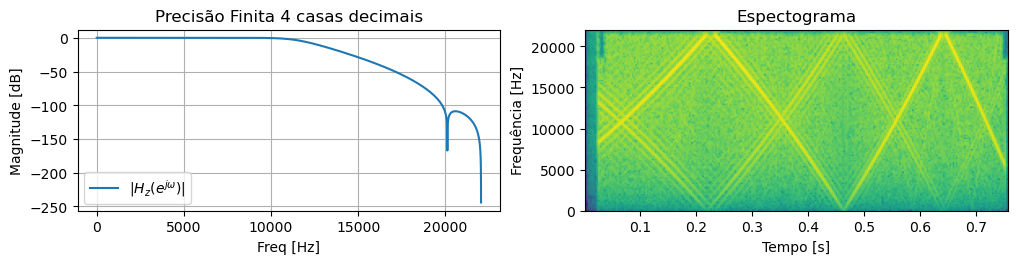

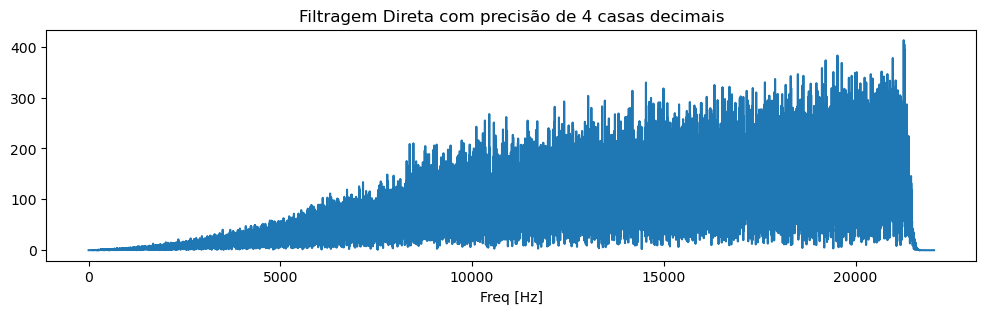

In [23]:
direct_4 = direct_form(
    samples, butterworth_discrete_4d.num, butterworth_discrete_4d.den
)

N = samples.shape[0]

plt.figure(figsize=(12, 8), dpi=100)

plt.subplot(3, 2, 1)

plt.plot(
    Wz_4d * 1 / (2 * np.pi) * Fs,
    20 * np.log10(np.abs(Hz_4d)),
    label=r"$|H_z(e^{j \omega})|$",
)

plt.legend()
plt.title("Precisão Finita 4 casas decimais")
plt.xlabel("Freq [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid()

# Plota espectograma do sinal filtrado
plt.subplot(3, 2, 2)
plt.specgram(direct_4, Fs=Fs, sides="onesided")
plt.title("Espectograma")
plt.xlabel("Tempo [s]")
plt.ylabel("Frequência [Hz]")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(direct_4)[0 : N // 2]))
plt.title("Filtragem Direta com precisão de 4 casas decimais")
plt.xlabel("Freq [Hz]")
plt.show()

Audio(direct_4, rate=sample_rate)

##### 3.2.3. Preciasão finita de 3 casas decimais

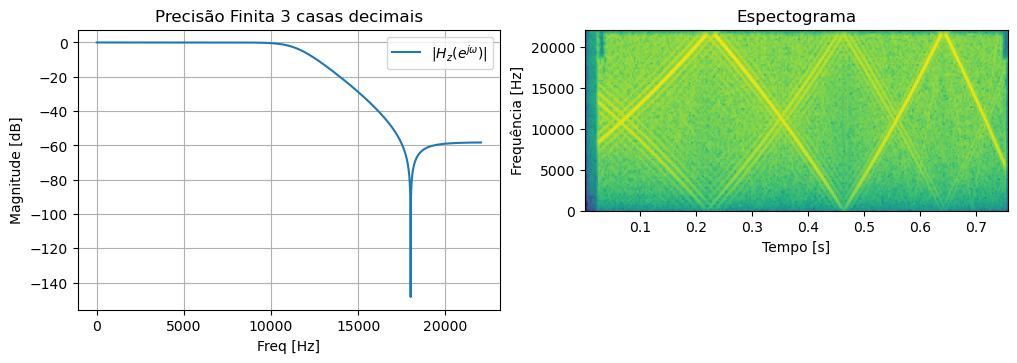

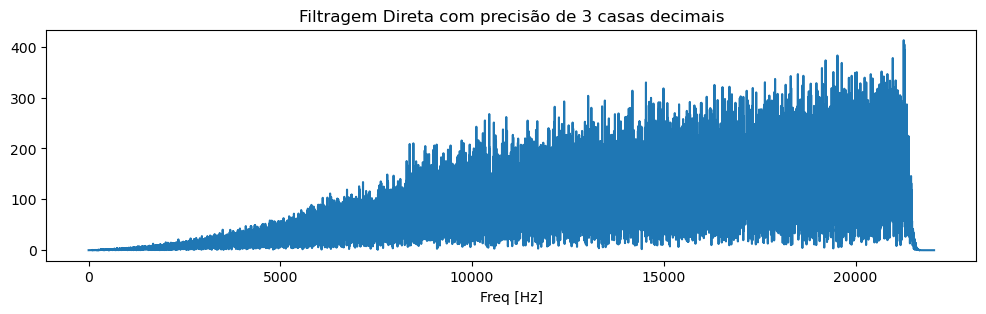

In [24]:
direct_3 = direct_form(
    samples, butterworth_discrete_3d.num, butterworth_discrete_3d.den
)
N = samples.shape[0]

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)

plt.plot(
    Wz_3d * 1 / (2 * np.pi) * Fs,
    20 * np.log10(np.abs(Hz_3d)),
    label=r"$|H_z(e^{j \omega})|$",
)

plt.legend()
plt.title("Precisão Finita 3 casas decimais")
plt.xlabel("Freq [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid()

# Plota espectograma do sinal filtrado
plt.subplot(3, 2, 2)
plt.specgram(direct_3, Fs=Fs, sides="onesided")
plt.title("Espectograma")
plt.xlabel("Tempo [s]")
plt.ylabel("Frequência [Hz]")
plt.show()


plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(direct_3)[0 : N // 2]))
plt.title("Filtragem Direta com precisão de 3 casas decimais")
plt.xlabel("Freq [Hz]")
plt.show()

Audio(direct_3, rate=sample_rate)

##### 3.2.4. Transformação $Z^{-1} = -z^{-1}$

In [25]:
def transform_1st(b, a):
    transformed_b = []
    transformed_a = []

    for i, value in enumerate(b):
        if i % 2 == b.shape[0] % 2:
            transformed_b.append(-value)
        else:
            transformed_b.append(value)

    for i, value in enumerate(a):
        if i % 2 == a.shape[0] % 2:
            transformed_a.append(-value)
        else:
            transformed_a.append(value)

    return transformed_b, transformed_a

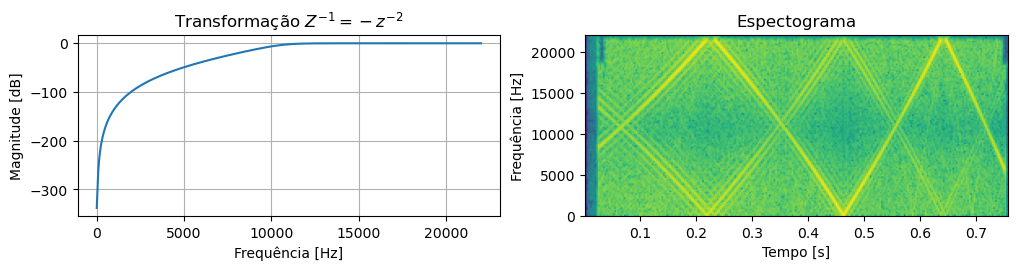

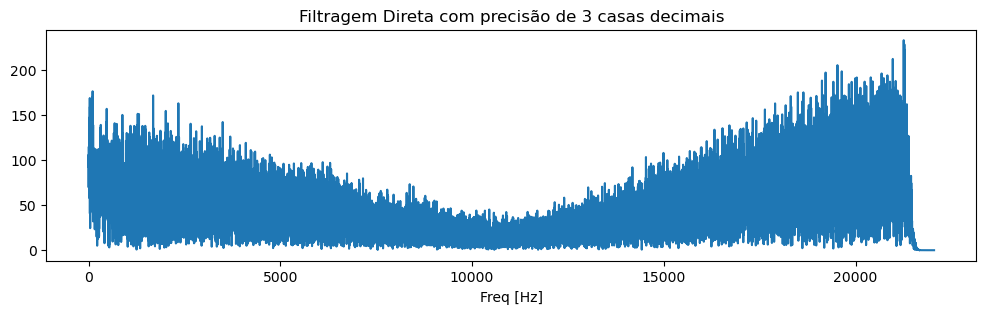

In [26]:
signal_1st_transform = signal.dlti(
    *transform_1st(butterworth_discrete.num, butterworth_discrete.den)
)

filtered_1st_transform = direct_form(
    samples, signal_1st_transform.num, signal_1st_transform.den)

Wz, Hz = signal.freqz(signal_1st_transform.num, signal_1st_transform.den)

plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.plot(
    Wz * Fs/(2 * np.pi),
    20 * np.log10(np.abs(Hz)),
    label=r'$|H_z(e^{j \omega})|$'
)
plt.title('Transformação ' + r'$Z^{-1} = -z^{-2}$')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.specgram(filtered_1st_transform, Fs=Fs, sides='onesided')
plt.title('Espectograma')
plt.xlabel('Tempo [s]')
plt.ylabel('Frequência [Hz]')
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(filtered_1st_transform)[0: N // 2]))
plt.title("Filtragem Direta com precisão de 3 casas decimais")
plt.xlabel("Freq [Hz]")
plt.show()

Audio(filtered_1st_transform, rate=sample_rate)


##### 3.2.5. Transformação $Z^{-1} = z^{-2}$

In [27]:
def transform_2nd(b, a):
    transformed_b = []
    transformed_a = []

    for coef_b in b:
        transformed_b.append(coef_b)
        transformed_b.append(0)

    for coef_a in a:
        transformed_a.append(coef_a)
        transformed_a.append(0)

    transformed_b = np.array(transformed_b[:-1])
    transformed_a = np.array(transformed_a[:-1])

    return transformed_b, transformed_a


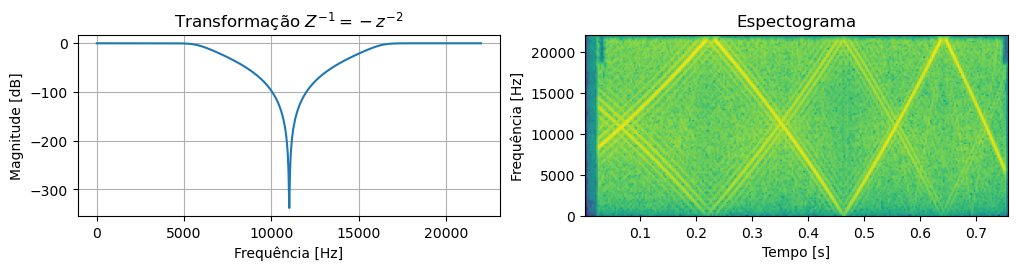

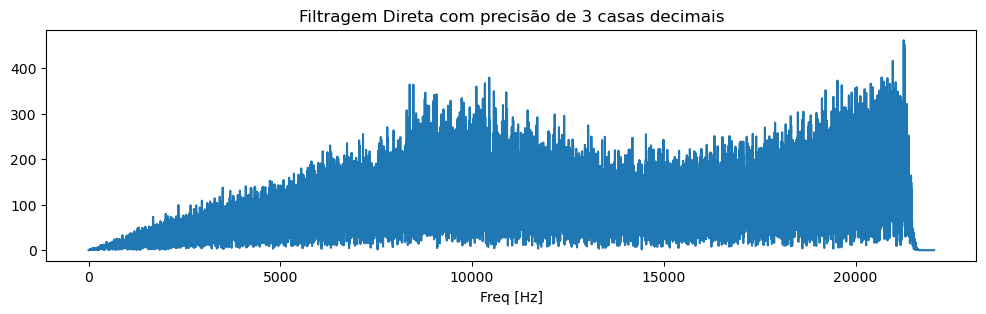

In [28]:
signal_2nd_transform = signal.dlti(
    *transform_2nd(butterworth_discrete.num, butterworth_discrete.den)
)

filtered_2nd_transform = direct_form(
    samples, signal_2nd_transform.num, signal_2nd_transform.den)

Wz, Hz = signal.freqz(signal_2nd_transform.num, signal_2nd_transform.den)

plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.plot(
    Wz * Fs/(2 * np.pi),
    20 * np.log10(np.abs(Hz)),
    label=r'$|H_z(e^{j \omega})|$'
)
plt.title('Transformação ' + r'$Z^{-1} = -z^{-2}$')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.specgram(filtered_2nd_transform, Fs=Fs, sides='onesided')
plt.title('Espectograma')
plt.xlabel('Tempo [s]')
plt.ylabel('Frequência [Hz]')
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(filtered_2nd_transform)[0: N // 2]))
plt.title("Filtragem Direta com precisão de 3 casas decimais")
plt.xlabel("Freq [Hz]")
plt.show()

Audio(filtered_2nd_transform, rate=sample_rate)


##### 3.2.6. Transformação $Z^{-1} = -z^{-2}$

In [29]:
def transform_3rd(b, a):
    return transform_2nd(*transform_1st(b, a))


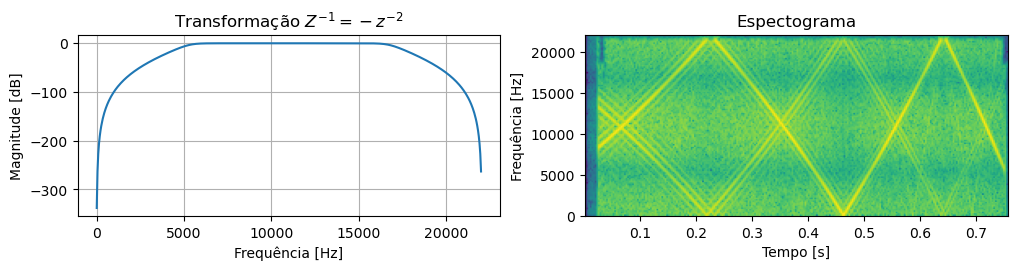

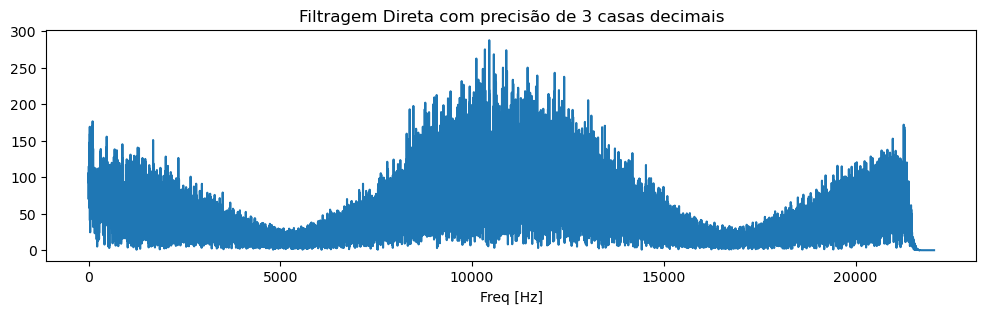

In [30]:
signal_3rd_transform = signal.dlti(
    *transform_3rd(butterworth_discrete.num, butterworth_discrete.den)
)

filtered_3rd_transform = direct_form(samples, signal_3rd_transform.num, signal_3rd_transform.den)

Wz, Hz = signal.freqz(signal_3rd_transform.num, signal_3rd_transform.den)

plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.plot(
    Wz * Fs/(2 * np.pi),
    20 * np.log10(np.abs(Hz)),
    label=r'$|H_z(e^{j \omega})|$'
)
plt.title('Transformação ' + r'$Z^{-1} = -z^{-2}$')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.specgram(filtered_3rd_transform, Fs=Fs, sides='onesided')
plt.title('Espectograma')
plt.xlabel('Tempo [s]')
plt.ylabel('Frequência [Hz]')
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(frequency_fft, 2.0 / N * np.abs(fft(filtered_3rd_transform)[0: N // 2]))
plt.title("Filtragem Direta com precisão de 3 casas decimais")
plt.xlabel("Freq [Hz]")
plt.show()

Audio(filtered_3rd_transform, rate=sample_rate)
